In [1]:
!pip install -r requirements.txt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import tensorflow as tf
print(tf.__version__)

import os
from os import listdir
from transformers import ( 
    T5Tokenizer, 
    TFT5ForConditionalGeneration
)
import numpy as np
import time

import pickle

# import python files
import sys
sys.path.append("../..")

from python_files.evaluation.mover_score import MoverScore, MyMoverScore
from python_files.evaluation.rouge_score import RougeScore
from python_files.language_tokens import LanguageTokens
from python_files.model_loader import ModelLoader
from python_files.output_tools.latex_table_writer import LatexTableWriter
from python_files.tf_record_loader import TFRecordLoader
from python_files.summary_generator import SummaryGenerator
# from python_files.summary_data import SummaryData

2.4.1


In [4]:
!nvidia-smi

Tue Apr 20 13:37:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:08:00.0  On |                  N/A |
| 36%   46C    P0    53W / 260W |   1288MiB / 11016MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Params

In [5]:
model_size = "t5-base"

MAX_ARTICLE_LEN = 512

MAX_HIGHLIGHT_LEN = 150

BATCH_SIZE = 8

root_folder = "../.."

result_folder = root_folder + "/results/"

## Language Tokens

In [6]:
tokenizer = T5Tokenizer.from_pretrained(model_size)
language_tokens = LanguageTokens(tokenizer, "tf")
prefix_size = language_tokens.prefix_size
language_token_order = ["de_de", "en_de", "de_en", "en_en"]

## Load data From Diretory

In [7]:
tf_record_loader = TFRecordLoader(root_folder, language_tokens, prefix_size, MAX_ARTICLE_LEN, MAX_HIGHLIGHT_LEN, BATCH_SIZE)

test_dataset = tf_record_loader.get_tfrecord_dataset("/data/sueddeutsche_test/")
test_dataset.prefetch(1024)

<PrefetchDataset shapes: ((None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150)), types: (tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32)>

## Model Loader

In [7]:
model_loader = ModelLoader(model_size, root_folder+"/models", "t5_sueddeutsche_plus_translation") 
# model_loader.yield_models()

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


## Score Functions

In [8]:
mover_score = MoverScore()

def get_new_score_dicts():
    rouge_score_dict = {
        language_token_order[0]: RougeScore(),
        language_token_order[1]: RougeScore(),
        language_token_order[2]: RougeScore(),
        language_token_order[3]: RougeScore()
    }

    mover_score_dict = {
        language_token_order[0]: MyMoverScore(mover_score),
        language_token_order[1]: MyMoverScore(mover_score),
        language_token_order[2]: MyMoverScore(mover_score),
        language_token_order[3]: MyMoverScore(mover_score)
    }
    return rouge_score_dict, mover_score_dict
test = get_new_score_dicts()

In [9]:
def get_scores(data_dict, batch_size):
    results = []
    rouge_score_dict, mover_score_dict = get_new_score_dicts()
    for i, epoch in data_dict.items():
        mover_score_list = []
        batch_predicted = []
        batch_real = []
        
        j = 0
        for item in epoch:
            rouge_score_dict[item['language_tag']](item['real_data'], item['pred_data'])
            mover_score_dict[item['language_tag']](item['real_data'], item['pred_data'])
            
        results.append((rouge_score_dict.copy(), mover_score_dict.copy()))
        rouge_score_dict, mover_score_dict = get_new_score_dicts()
        print("Epoch: {} done".format(i))
    return results

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
 
class MyScore:
    def __init__(self)-> None:
        super().__init__()
        self.de_de = []
        self.de_en = []
        self.en_de = []
        self.en_en = []
        self.mover_score_de_de = []
        self.mover_score_de_en = []
        self.mover_score_en_de = []
        self.mover_score_en_en = []

        self.score_order = ["rouge1", "rouge2", "rougeLsum"]
       
    def __call__(self, token, rouge_score, mover_score):
        if token == "de_de":
            self.de_de.append(np.array([rouge_score["rouge1"], rouge_score["rouge2"], rouge_score["rougeLsum"]]))
            self.mover_score_de_de.append(mover_score)
        elif token == "de_en":
            self.de_en.append(np.array([rouge_score["rouge1"], rouge_score["rouge2"], rouge_score["rougeLsum"]]))
            self.mover_score_de_en.append(mover_score)
        elif token == "en_de":
            self.en_de.append(np.array([rouge_score["rouge1"], rouge_score["rouge2"], rouge_score["rougeLsum"]]))
            self.mover_score_en_de.append(mover_score)
        elif token == "en_en":
            self.en_en.append(np.array([rouge_score["rouge1"], rouge_score["rouge2"], rouge_score["rougeLsum"]]))
            self.mover_score_en_en.append(mover_score)
        else:
            print("ERROR: token not known")
     
    @staticmethod
    def shift_array_right(x):
        zero_fill_up = np.zeros([1,x.shape[1]], dtype=np.float64)
        return np.concatenate([zero_fill_up, x])

    def plot_one(self, axs, title, arr):

        axs.set_title("ROUGE score: " + title)
        axs.set_ylim(0, 44)
        axs.set_xlim(1,10)
        
        arr = self.shift_array_right(arr)
        for j in range(3):
            axs.plot(arr[:,j], label=self.score_order[j])
        axs.legend()
 
    def plot(self):
        
        fig = plt.figure(constrained_layout=True, figsize=(12, 8))
        spec = plt.GridSpec(2, 3, figure=fig)
        f_ax1 = fig.add_subplot(spec[0, 0])
        f_ax2 = fig.add_subplot(spec[0, 1])
        f_ax3 = fig.add_subplot(spec[1, 0])
        f_ax4 = fig.add_subplot(spec[1, 1])
        self.plot_one(f_ax1, "de to de", np.array(self.de_de))
        self.plot_one(f_ax2, "de to en", np.array(self.de_en))
        self.plot_one(f_ax3, "en to de", np.array(self.en_de))
        self.plot_one(f_ax4, "en to en", np.array(self.en_en))
        
        f_ax5 = fig.add_subplot(spec[:, 2])
        f_ax5.set_title("Mover Score")
        f_ax5.set_xlim(1,10)
        f_ax5.plot(np.array([self.mover_score_de_de[0]] + self.mover_score_de_de), label="de to de")
        f_ax5.plot(np.array([self.mover_score_de_de[0]] + self.mover_score_de_en), label="de to en")
        f_ax5.plot(np.array([self.mover_score_de_de[0]] + self.mover_score_en_de), label="en to de")
        f_ax5.plot(np.array([self.mover_score_de_de[0]] + self.mover_score_en_en), label="en to en")
        f_ax5.legend()
        plt.show()
        

        print("rouge_score max: ", "de to de", np.argmax(np.array(self.de_de), axis=0))
        print("rouge_score max: ", "de to en", np.argmax(np.array(self.de_en), axis=0))
        print("rouge_score max: ", "en to de", np.argmax(np.array(self.en_de), axis=0))
        print("rouge_score max: ", "en to en", np.argmax(np.array(self.en_en), axis=0))
        
    @staticmethod
    def append_to_lists(list1, list2, list3, item):
        
        list1.append(item[0])
        list2.append(item[1])
        list3.append(item[2])
    
    @staticmethod
    def get_propotion_of_baseline(x, baseline): 
        print(baseline, x)
        propotion = x / baseline 
        print(propotion)
        ret_list = []
        for x_i, p in zip(x, propotion):
            ret_list.append("{:.2f} ({:.2f})".format(x_i, p))
        return ret_list
        
    def get_latex_table(self, table_name, caption):
        print(self.mover_score_de_de[0])
        print(self.de_de[0])
        latex_table_dict = {
            'Scores': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'MoverScore'],
            'German to German':  list(self.de_de[0]) + [self.mover_score_de_de[0]],
            'English to English':  list(self.en_en[0]) +  [self.mover_score_en_en[0]],
            'English to German': self.get_propotion_of_baseline(self.en_de[0], self.de_de[0]) + [self.mover_score_en_de[0]],
            'German to English': self.get_propotion_of_baseline(self.de_en[0], self.en_en[0]) + [self.mover_score_de_en[0]]
        }
        print(latex_table_dict)
        latex_table_writer = LatexTableWriter()
        return latex_table_writer.write_table(table_name, latex_table_dict, caption) 
     

# Generation

## Generate Summarize
- Generate 240 / epoch

In [10]:
result_folder = root_folder + "/results/"
result_path = result_folder + "sued_plus_trans_epochs/"

In [11]:
skip_till_already_done = 0

for i, model in enumerate(model_loader.yield_models()):
    print("Epoch: ", i)
    if i < skip_till_already_done:
        print("Already done.")
    else:
        summary_gen = SummaryGenerator(tokenizer, language_token_order, False, epoch=i)
        predictions = summary_gen.generate_summaries(model, test_dataset, result_path, break_point=30)

../../models/t5_sueddeutsche_plus_translation/t5_sueddeutsche_plus_translation_t5_base-0.ckpt
Epoch:  0
[10]: time generating 10 batches: 364.3726272583008
[20]: time generating 10 batches: 355.94463205337524
[30]: time generating 10 batches: 328.62798523902893
../../models/t5_sueddeutsche_plus_translation/t5_sueddeutsche_plus_translation_t5_base-1.ckpt
Epoch:  1
0
[10]: time generating 10 batches: 328.9304370880127
[20]: time generating 10 batches: 332.8988091945648
[30]: time generating 10 batches: 314.1094250679016
../../models/t5_sueddeutsche_plus_translation/t5_sueddeutsche_plus_translation_t5_base-2.ckpt
Epoch:  2
1
[10]: time generating 10 batches: 285.0888018608093
[20]: time generating 10 batches: 334.03853845596313
[30]: time generating 10 batches: 303.4998595714569
../../models/t5_sueddeutsche_plus_translation/t5_sueddeutsche_plus_translation_t5_base-3.ckpt
Epoch:  3
2
[10]: time generating 10 batches: 245.47365927696228
[20]: time generating 10 batches: 320.46961998939514
[

## Load data from pickle file

In [12]:
predictions_dict = {}
epoch_files = listdir(result_path)
epoch_files.sort()
for i, file_name in enumerate(epoch_files):
    with open(result_path + file_name, "rb") as file:
        predictions_dict[i] = pickle.load(file)

In [15]:
scores = get_scores(predictions_dict, 16)

Epoch: 0 done
Epoch: 1 done
Epoch: 2 done
Epoch: 3 done
Epoch: 4 done
Epoch: 5 done
Epoch: 6 done
Epoch: 7 done
Epoch: 8 done
Epoch: 9 done
Epoch: 10 done
Epoch: 11 done


In [16]:
latex_table_writer = LatexTableWriter()

[0]----- de_de -----
rouge1 = 47.08, 95% confidence [42.46, 51.70]
rouge2 = 38.29, 95% confidence [32.62, 43.98]
rougeLsum = 44.04, 95% confidence [39.55, 48.93]
Moverscore: 0.68
[0]----- en_de -----
rouge1 = 35.97, 95% confidence [32.76, 39.41]
rouge2 = 20.44, 95% confidence [17.53, 23.42]
rougeLsum = 31.63, 95% confidence [28.40, 34.98]
Moverscore: 0.59
[0]----- de_en -----
rouge1 = 39.15, 95% confidence [36.39, 42.21]
rouge2 = 19.91, 95% confidence [17.19, 22.84]
rougeLsum = 33.67, 95% confidence [30.70, 36.64]
Moverscore: 0.58
[0]----- en_en -----
rouge1 = 49.59, 95% confidence [45.08, 53.91]
rouge2 = 37.78, 95% confidence [32.73, 42.80]
rougeLsum = 45.52, 95% confidence [40.74, 50.09]
Moverscore: 0.65
[1]----- de_de -----
rouge1 = 48.25, 95% confidence [43.62, 53.15]
rouge2 = 38.68, 95% confidence [33.43, 44.18]
rougeLsum = 44.96, 95% confidence [39.63, 50.16]
Moverscore: 0.69
[1]----- en_de -----
rouge1 = 37.97, 95% confidence [34.60, 41.56]
rouge2 = 22.69, 95% confidence [19.37,

Moverscore: 0.61
[11]----- de_en -----
rouge1 = 45.14, 95% confidence [40.92, 49.37]
rouge2 = 27.57, 95% confidence [23.47, 32.06]
rougeLsum = 39.97, 95% confidence [35.62, 44.09]
Moverscore: 0.61
[11]----- en_en -----
rouge1 = 51.02, 95% confidence [45.90, 56.36]
rouge2 = 38.82, 95% confidence [32.34, 44.70]
rougeLsum = 47.08, 95% confidence [41.92, 52.92]
Moverscore: 0.68


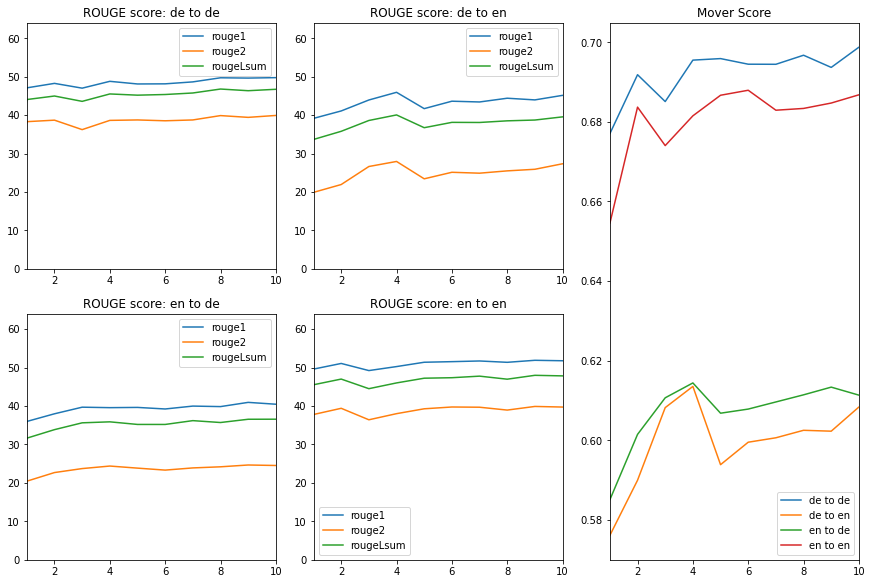

rouge_score max:  de to de [9 9 7]
rouge_score max:  de to en [3 3 3]
rouge_score max:  en to de [8 8 9]
rouge_score max:  en to en [8 8 8]


In [18]:
my_score = MyScore()
for i, (rouge_score, mover_score) in enumerate(scores):
    for token in language_token_order:
        print("[{}]----- {} -----".format(i, token))
        rouge_scores = rouge_score[token].result()
        mover_scores = mover_score[token].result()
        my_score(token, rouge_scores, mover_scores)

    
my_score.plot()

## Load Model with best rouge score

In [12]:
model = model_loader.load_epoch(11)
result_full_ds_path = result_folder + "t5_sueddeutsche_plus_translation/"

In [13]:
summary_gen = SummaryGenerator(tokenizer, language_token_order, True)

In [14]:
predictions = summary_gen.generate_summaries(model, test_dataset, result_full_ds_path, use_break_point=False)

680
[690]: time generating 10 batches: 299.70536065101624
[700]: time generating 10 batches: 283.32659363746643
[710]: time generating 10 batches: 289.314581155777
[720]: time generating 10 batches: 289.743928194046
[730]: time generating 10 batches: 284.9334177970886
[740]: time generating 10 batches: 278.30355978012085
[750]: time generating 10 batches: 296.83659410476685
[760]: time generating 10 batches: 296.45511293411255
[770]: time generating 10 batches: 292.79934644699097
[780]: time generating 10 batches: 298.0448455810547
[790]: time generating 10 batches: 299.8876540660858
[800]: time generating 10 batches: 290.2708442211151
[810]: time generating 10 batches: 283.47915959358215
[820]: time generating 10 batches: 294.76018500328064
[830]: time generating 10 batches: 296.66177201271057
[840]: time generating 10 batches: 294.8384211063385
[850]: time generating 10 batches: 295.54820227622986
[860]: time generating 10 batches: 298.31979417800903
[870]: time generating 10 batches

## Load data and show result table

In [11]:
result_full_ds_path = result_folder + "t5_sueddeutsche_plus_translation/"
predictions_dict = {}
predictions = []

epoch_files = listdir(result_full_ds_path)
epoch_files.sort()
for i, file_name in enumerate(epoch_files):
    with open(result_full_ds_path + file_name, "rb") as file:
        [predictions.append(item) for item in pickle.load(file)]
        
predictions_dict[0] = predictions

In [12]:
scores = get_scores(predictions_dict, 16)

Epoch: 0 done


In [13]:
my_score = MyScore()
for i, (rouge_score, mover_score) in enumerate(scores):
    for token in language_token_order:
        print("[{}]----- {} -----".format(i, token))
        my_score(token, rouge_score[token].result(), mover_score[token].result())

[0]----- de_de -----
rouge1 = 44.51, 95% confidence [43.76, 45.26]
rouge2 = 34.81, 95% confidence [34.03, 35.60]
rougeLsum = 41.32, 95% confidence [40.54, 42.00]
Moverscore: 0.67
[0]----- en_de -----
rouge1 = 37.44, 95% confidence [36.91, 37.99]
rouge2 = 21.82, 95% confidence [21.34, 22.30]
rougeLsum = 32.94, 95% confidence [32.45, 33.46]
Moverscore: 0.60
[0]----- de_en -----
rouge1 = 42.36, 95% confidence [41.88, 42.84]
rouge2 = 24.23, 95% confidence [23.72, 24.72]
rougeLsum = 36.68, 95% confidence [36.18, 37.22]
Moverscore: 0.60
[0]----- en_en -----
rouge1 = 48.61, 95% confidence [47.95, 49.27]
rouge2 = 35.75, 95% confidence [34.95, 36.50]
rougeLsum = 43.97, 95% confidence [43.31, 44.67]
Moverscore: 0.67


In [15]:
print(my_score.get_latex_table("Result scores of the 12th epoch test data from the sueddeutsche dataset.", "final_results_suedd"))

0.6730672615963363
[44.50788701 34.8113304  41.31792617]
[44.50788701 34.8113304  41.31792617] [37.43764706 21.81648789 32.94255675]
[0.84114636 0.62670652 0.79729454]
[48.61380182 35.75275939 43.97279729] [42.35966854 24.23159057 36.67974857]
[0.87135066 0.67775442 0.83414635]
{'Scores': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'MoverScore'], 'German to German': [44.50788701337756, 34.81133039933636, 41.317926170323815, 0.6730672615963363], 'English to English': [48.61380181806921, 35.752759393001526, 43.97279729067506, 0.6665502885174939], 'English to German': ['37.44 (0.84)', '21.82 (0.63)', '32.94 (0.80)', 0.6015770472515833], 'German to English': ['42.36 (0.87)', '24.23 (0.68)', '36.68 (0.83)', 0.5975316696020878]}
\begin{table}[htb]
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|}
			\hline
			Scores & German to German & English to English & English to German & German to English\\
			\hline\hline
			ROUGE-1 & 44.51 & 48.61 & 37.44 (0.84) & 42.36 (0.87)\\
			ROUGE-2 & 34.81 & 35.75 & 21.82